## Set UP

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, set_random_seed
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import layers

In [3]:
df_full = pd.read_csv('/Users/kelianneheinz/MIDS/courses/W210_Capstone/model_data/m1_results_face_angled.csv')
df_full.dropna(subset=['Pose'], inplace=True)

In [4]:
# Split out and rename belndshape features
def get_features(df):
    features = df.blendshapes.str.replace('[', '', regex=True)\
        .str.replace(']', '', regex=True).str.replace("'", '', regex=True)\
            .str.split(', ', expand=True).astype(float)
    feature_names = {
    0:'browDownLeft', 1:'browDownRight', 2:'browInnerUp', 3:'browOuterUpLeft',
    4:'browOuterUpRight', 5:'cheekPuff', 6:'cheekSquintLeft', 7:'cheekSquintRight',
    8:'eyeBlinkLeft', 9:'eyeBlinkRight', 10:'eyeLookDownLeft', 11:'eyeLookDownRight',
    12:'eyeLookInLeft', 13:'eyeLookInRight', 14:'eyeLookOutLeft', 15:'eyeLookOutRight',
    16:'eyeLookUpLeft', 17:'eyeLookUpRight', 18:'eyeSquintLeft', 19:'eyeSquintRight',
    20:'eyeWideLeft', 21:'eyeWideRight', 22:'jawForward', 23:'jawLeft',
    24:'jawOpen', 25:'jawRight', 26:'mouthClose', 27:'mouthDimpleLeft',
    28:'mouthDimpleRight', 29:'mouthFrownLeft', 30:'mouthFrownRight',
    31:'mouthFunnel', 32:'mouthLeft', 33:'mouthLowerDownLeft',
    34:'mouthLowerDownRight', 35:'mouthPressLeft', 36:'mouthPressRight',
    37:'mouthPucker', 38:'mouthRight', 39:'mouthRollLower', 40:'mouthRollUpper',
    41:'mouthShrugLower', 42:'mouthShrugUpper', 43:'mouthSmileLeft',
    44:'mouthSmileRight', 45:'mouthStretchLeft', 46:'mouthStretchRight',
    47:'mouthUpperUpLeft', 48:'mouthUpperUpRight', 49:'noseSneerLeft',
    50:'noseSneerRight', 51:'tongueOut'
    }
    features.rename(columns=feature_names, inplace=True)
    return features

# Split out labels
def get_labels(df):
    labels = df.Pose.astype(int)
    return labels

In [5]:
# seeds for split
SEED = 42
set_random_seed(SEED)

# test_creators
test_creators = ['Anna-Veronika', 'Blush-with-me-Parmita', 'Doctora-Claudia-Garcia',
                 'Gesund-durchs-Leben', 'Goldbeauty', 'Muscle-Watching-L', 'Natty',
                 'Pilates-by-Lisa', 'Shanthi-Kasiraj', 'Siddhi-yoga-hindi',
                 'templo-del-masaje']


## Experimenting

In [6]:
pose_7_squish = ['Anna-Veronika', 'Doctora-Claudia-Garcia', 'Siddhi-yoga-hindi', 'AVA-LEE', 'Face-Up', 'HisDream', 'MIZI', 'Verena-Boix', 'Yoga_Face']

In [7]:
pose_1_pull = ['isasaweis', 'LibertadDigital', 'FACEROBICS', 'thefaceyogalab', 'Pilates-by-Lisa', 'Face-Yoga-Method']
pose_1_press = ['AVA-LEE', 'Verena-Boix', 'Goldbeauty', 'The-Uma-Show', 'HisDream', 'Face-Yoga-Expert']

In [8]:
df = df_full.copy()
df[((df.face_angled != 1) | (df.Pose == 3))]
print(df[((df.face_angled != 1))].shape)
print(df[df.Pose == 3].shape)
print(df[((df.face_angled != 1) | (df.Pose == 3))].shape)

(6622, 12)
(560, 12)
(6778, 12)


In [9]:
df.head()

,Filename,blendshapes,landmarks,Pose,Face Obstructed,Hands on Face,Notes,poor_quality,face_angled,Creator,Gender,Apparent_Race
0,Pose_9_Yoga-with-Souvik_317.jpg,"[5.608021069747338e-07, 0.0013631416950374842,...","[(0.5571142435073853, 0.4451383352279663, -0.0...",0.0,0.0,0.0,NaN,0.0,0.0,Yoga-with-Souvik,M,Indian
1,Pose_9_Yoga-with-Souvik_316.jpg,"[7.196812248366768e-07, 0.002077932935208082, ...","[(0.5588706731796265, 0.440979927778244, -0.02...",0.0,0.0,0.0,NaN,0.0,0.0,Yoga-with-Souvik,M,Indian
2,Pose_9_Yoga-with-Souvik_315.jpg,"[1.1721351711457828e-07, 0.0010945542016997933...","[(0.5612891912460327, 0.42788931727409363, -0....",9.0,0.0,0.0,NaN,0.0,0.0,Yoga-with-Souvik,M,Indian
3,Pose_9_Yoga-with-Souvik_314.jpg,"[1.4378076684806729e-06, 0.022128582000732422,...","[(0.5560778379440308, 0.43858107924461365, -0....",0.0,0.0,0.0,NaN,0.0,0.0,Yoga-with-Souvik,M,Indian
4,Pose_9_Yoga-with-Souvik_313.jpg,"[5.819963462272426e-07, 0.007496405392885208, ...","[(0.560219943523407, 0.433199405670166, -0.028...",0.0,0.0,0.0,NaN,0.0,0.0,Yoga-with-Souvik,M,Indian


In [10]:
## DF alterations
df = df_full.copy()
df = df[df.poor_quality != 1]
df = df[((df.face_angled != 1) | (df.Pose == 3))]
# df = df[df.Pose != 0]
# df = df[~((df.Pose == 7) & (df['Hands on Face'] == 1))]
df.loc[df.Pose == 9, 'Pose'] = 6
df.loc[(df.Creator == 'Glowinface') & (df.Pose == 4), 'Pose'] = 8.0
## df = df[~((df.Creator.isin(pose_7_squish)) & (df.Pose == 7))]
df.loc[(df.Creator.isin(pose_1_press))& (df.Pose == 1), 'Pose'] = 9.0
std = False
# df.loc[(df.Creator.isin(pose_7_squish))& (df.Pose == 7), 'Pose'] = 10.0
experiment = "With Angled faces"

In [11]:
# Get Unique IDs
uid=df.Filename

# Get Creator names
creator=df.Creator

# Get number of classes
N_CLASSES = df.Pose.nunique()

## Test / training data set up
# Make df_train and df_test
## TODO Get rid of this step or figure out if its less computationally expensive to store
df_train = (df[~df.Creator.isin(test_creators)])
# print(f"Training data: {df_train.shape}")
df_test = df[df.Creator.isin(test_creators)]
# print(f"Testing data: {df_test.shape}")

# Get features
X_train = get_features(df[~df.Creator.isin(test_creators)])
print(f"Training feature set: {X_train.shape}")
X_test = get_features(df[df.Creator.isin(test_creators)])
print(f"Testing feature set: {X_test.shape}")

# Scale features
if std:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

# Creator based label split
# y_train = labels[creator.isin(train_creators)]
y_train = get_labels(df[~df.Creator.isin(test_creators)])
y_train_cat = to_categorical(y_train)
# y_test = labels[creator.isin(test_creators)]
y_test = get_labels(df[df.Creator.isin(test_creators)])
y_test_cat = to_categorical(y_test)

# Define class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

Training feature set: (5292, 52)
Testing feature set: (1747, 52)


In [1]:
from xgboost import XGBClassifier
# import f1_score
from sklearn.metrics import f1_score

In [12]:
df_pose = df.copy()
key_pose = 7
df_pose.loc[df_pose.Pose != key_pose, 'Pose'] = 0
df_pose.loc[df_pose.Pose == key_pose, 'Pose'] = 1

# Define class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_pose),
    y = df_pose)
class_weights = dict(zip(np.unique(df_pose), class_weights))

In [ ]:
model = XGBClassifier(class_weight=class_weights)
model.fit(X_train, y_train_6)
y_pred_6 = xgbc6.predict(X_test)
print(classification_report(y_test_6, y_pred_6))
# print(confusion_matrix(y_test_8, y_pred_8))
print(f"f1-score macro: {f1_score(y_test_6, y_pred_6, average='macro')}")
print(f"f1-score micro: {f1_score(y_test_6, y_pred_6, average='micro')}")

In [13]:
lr = LogisticRegression(class_weight='class_weights', solver='lbfgs', max_iter=1000)
lr.fit(X_train, y_train_8)
y_pred = lr.predict(X_test)
print(classification_report(y_test_8, y_pred))
print(confusion_matrix(y_test_8, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1452
           1       0.85      0.77      0.81       295

    accuracy                           0.94      1747
   macro avg       0.90      0.87      0.89      1747
weighted avg       0.94      0.94      0.94      1747

[[1413   39]
 [  69  226]]


In [15]:
from sklearn.metrics import f1_score
f1_score(y_test_8, y_pred, average='binary')

0.8071428571428572

In [118]:
import pickle

with open('xgbc8.pkl', 'wb') as f:
    pickle.dump(xgbc6, f)

In [127]:
from xgboost import XGBClassifier
# import f1_score
from sklearn.metrics import f1_score


In [132]:
model = XGBClassifier(class_weight=class_weights)
xgbc6.fit(X_train, y_train_6)
y_pred_6 = xgbc6.predict(X_test)
print(classification_report(y_test_6, y_pred_6))
# print(confusion_matrix(y_test_8, y_pred_8))
print(f"f1-score macro: {f1_score(y_test_6, y_pred_6, average='macro')}")
print(f"f1-score micro: {f1_score(y_test_6, y_pred_6, average='micro')}")

[10:38:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1452
           1       0.86      0.77      0.81       295

    accuracy                           0.94      1747
   macro avg       0.91      0.87      0.89      1747
weighted avg       0.94      0.94      0.94      1747

f1-score macro: 0.8878696797927024
f1-score micro: 0.9398969662278193


In [99]:
!pip install xgboost --upgrade

In [67]:
import pickle

with open('xgbc6.pkl', 'wb') as f:
    pickle.dump(xgbc6, f)

In [52]:
# Creator Based Test/Train Split
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000, class_weight=class_weights)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(experiment)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred)}')
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Without angled faces 
Logistic Regression Accuracy: 0.7348530293941212
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.56      0.69       321
           1       0.57      0.93      0.70        60
           2       0.66      0.98      0.79       111
           3       0.56      0.95      0.70       119
           4       1.00      0.79      0.88        89
           5       0.98      1.00      0.99       122
           6       0.80      0.75      0.78       285
           7       0.65      0.55      0.60       327
           8       0.88      0.84      0.86       122
           9       0.55      0.69      0.62       111

    accuracy                           0.73      1667
   macro avg       0.75      0.80      0.76      1667
weighted avg       0.76      0.73      0.73      1667



In [55]:
# Creator Based Test/Train Split
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000, class_weight=class_weights)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(experiment)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred)}')
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

OG
Logistic Regression Accuracy: 0.6973684210526315
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73       332
           1       0.59      0.51      0.55       171
           2       0.67      0.92      0.77       127
           3       0.55      0.95      0.70       119
           4       1.00      0.56      0.72       103
           5       0.95      0.94      0.94       142
           6       0.28      0.60      0.38        73
           7       0.59      0.58      0.58       337
           8       0.93      0.86      0.89       122
           9       0.87      0.72      0.79       222

    accuracy                           0.70      1748
   macro avg       0.73      0.73      0.71      1748
weighted avg       0.75      0.70      0.71      1748



In [61]:
# Creator Based Test/Train Split
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000, class_weight=class_weights)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(experiment)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred)}')
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

With Angled faces
Logistic Regression Accuracy: 0.7298225529479107
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.56      0.68       332
           1       0.57      0.93      0.70        60
           2       0.69      0.94      0.80       127
           3       0.56      0.95      0.70       119
           4       1.00      0.76      0.86       103
           5       0.94      0.94      0.94       142
           6       0.77      0.71      0.74       295
           7       0.63      0.59      0.61       336
           8       0.86      0.85      0.86       122
           9       0.59      0.70      0.64       111

    accuracy                           0.73      1747
   macro avg       0.75      0.79      0.75      1747
weighted avg       0.76      0.73      0.73      1747



In [462]:
classification_dict = classification_report(y_test, y_pred, output_dict=True)
f1_scores = []
for i in range(int(df.Pose.min()), int(df.Pose.min()) + N_CLASSES):
    f1_scores.append(round(classification_dict[str(i)]['f1-score'], 4))
print(experiment)
print(round(classification_dict['accuracy'],4))
print(round(classification_dict['macro avg']['precision'],4))
print(round(classification_dict['macro avg']['recall'],4))
print(round(classification_dict['macro avg']['f1-score'],4))
print(f1_scores)

Pose 1 split
0.7254
0.7392
0.7799
0.7424
[0.7217, 0.6849, 0.7178, 0.6552, 0.8249, 0.9379, 0.7452, 0.601, 0.8287, 0.7063]


In [472]:
classification_dict = classification_report(y_test, y_pred, output_dict=True)
f1_scores = []
for i in range(int(df.Pose.min()), int(df.Pose.min()) + N_CLASSES):
    f1_scores.append(round(classification_dict[str(i)]['f1-score'], 4))
print(experiment)
print(round(classification_dict['accuracy'],4))
print(round(classification_dict['macro avg']['precision'],4))
print(round(classification_dict['macro avg']['recall'],4))
print(round(classification_dict['macro avg']['f1-score'],4))
print(f1_scores)

Pose 1 combined
0.718
0.751
0.7545
0.7375
[0.766, 0.6286, 0.7168, 0.6514, 0.7907, 0.9379, 0.74, 0.5745, 0.8314]


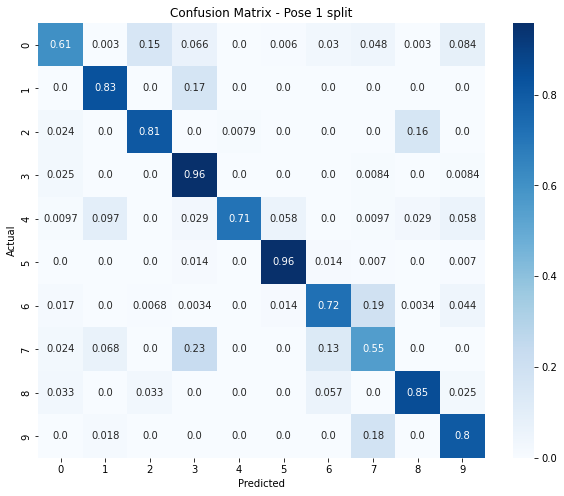

In [463]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2')
plt.xlabel('Predicted')
# set ticks for y-axis
# plt.yticks(['0','1','2','3','4','5','7','8','9'])
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {experiment}')
plt.show()

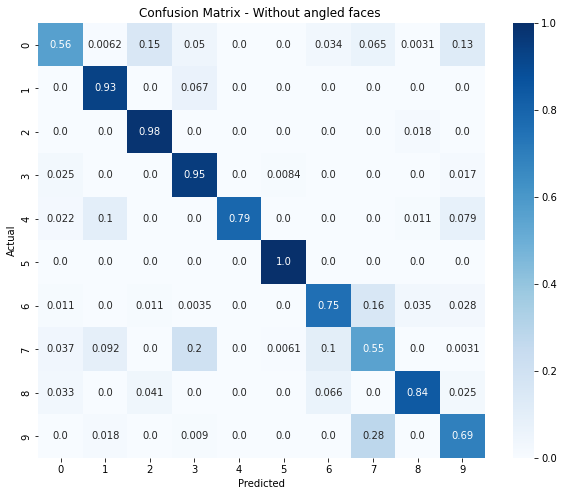

In [45]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2')
plt.xlabel('Predicted')
# set ticks for y-axis
# plt.yticks(['0','1','2','3','4','5','7','8','9'])
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {experiment}')
plt.show()

## RCA

In [464]:
y_pred_train = lr.predict(X_train)


In [465]:
# Append predictions to df_test
df_results_test = df_test[['Filename', 'Pose', 'Face Obstructed', 'Hands on Face', 'Notes', 'Creator', 'Gender', 'Apparent_Race']].copy()
df_results_test['pred'] = y_pred
df_results_test['accurate'] = df_results_test['pred'] == df_results_test['Pose']
df_results_test['set'] = 'test'

In [466]:
# Append predictions to df_train
df_results_train = df_train[['Filename', 'Pose', 'Face Obstructed', 'Hands on Face', 'Notes', 'Creator', 'Gender', 'Apparent_Race']].copy()
df_results_train['pred'] = y_pred_train
df_results_train['accurate'] = df_results_train['pred'] == df_results_train['Pose']
df_results_train['set'] = 'train'
df_results = pd.concat([df_results_test, df_results_train])
df_results.head()

,Filename,Pose,Face Obstructed,Hands on Face,Notes,Creator,Gender,Apparent_Race,pred,accurate,set
20896,og-Pose_9_Siddhi-yoga-hindi_2228.jpg,6.0,0.0,0.0,NaN,Siddhi-yoga-hindi,M,Indian,5,False,test
20897,og-Pose_9_Siddhi-yoga-hindi_2227.jpg,6.0,0.0,0.0,NaN,Siddhi-yoga-hindi,M,Indian,6,True,test
20898,og-Pose_9_Siddhi-yoga-hindi_2226.jpg,6.0,0.0,0.0,NaN,Siddhi-yoga-hindi,M,Indian,7,False,test
20899,og-Pose_9_Siddhi-yoga-hindi_2225.jpg,6.0,0.0,0.0,NaN,Siddhi-yoga-hindi,M,Indian,5,False,test
20900,og-Pose_9_Siddhi-yoga-hindi_2224.jpg,6.0,0.0,0.0,NaN,Siddhi-yoga-hindi,M,Indian,7,False,test


In [467]:
# Find number of accurate predictions by creator
a = (df_results[(df_results['Pose'] == 1)].groupby(['set','Creator'])['accurate'].count())
b = (df_results[(df_results['Pose'] == 1)].groupby(['set','Creator'])['accurate'].sum())

print(f"Count of wrong predictions: \n{a - b}")
print(f"Percent of wrong predictions: \n{(a - b) / a}")

Count of wrong predictions: 
set    Creator         
test   Pilates-by-Lisa     10
train  FACEROBICS          24
       Face-Yoga-Method    28
       LibertadDigital     20
       isasaweis            1
       thefaceyogalab       8
Name: accurate, dtype: int64
Percent of wrong predictions: 
set    Creator         
test   Pilates-by-Lisa     0.166667
train  FACEROBICS          0.106667
       Face-Yoga-Method    0.088889
       LibertadDigital     0.142857
       isasaweis           0.013333
       thefaceyogalab      0.059259
Name: accurate, dtype: float64


In [355]:
df_results[(df_results['Pose'] == 4) & (df_results['Creator'] == 'Anna-Veronika')]

,Filename,Pose,Face Obstructed,Hands on Face,Notes,Creator,Gender,Apparent_Race,pred,accurate,set
24831,og-Pose_4_Anna-Veronika_330.jpg,4.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,5,False,test
24832,og-Pose_4_Anna-Veronika_329.jpg,4.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,4,True,test
24833,og-Pose_4_Anna-Veronika_316.jpg,4.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,3,False,test
24834,og-Pose_4_Anna-Veronika_315.jpg,4.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,5,False,test
24847,og-Pose_4_Anna-Veronika_260.jpg,4.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,4,True,test
24848,og-Pose_4_Anna-Veronika_259.jpg,4.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,5,False,test
24849,og-Pose_4_Anna-Veronika_258.jpg,4.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,5,False,test
24850,og-Pose_4_Anna-Veronika_257.jpg,4.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,5,False,test
24851,og-Pose_4_Anna-Veronika_256.jpg,4.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,6,False,test
24869,og-Pose_4_Anna-Veronika_229.jpg,4.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,5,False,test


In [367]:
df_results[(df_results['Creator'] == 'Anna-Veronika') 
           & (df_results.Filename.str[-7:-4] < '335')
           & (df_results.Filename.str[-7:-4] > '300')]


,Filename,Pose,Face Obstructed,Hands on Face,Notes,Creator,Gender,Apparent_Race,pred,accurate,set
24827,og-Pose_4_Anna-Veronika_334.jpg,0.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,0,True,test
24828,og-Pose_4_Anna-Veronika_333.jpg,5.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,7,False,test
24829,og-Pose_4_Anna-Veronika_332.jpg,5.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,7,False,test
24830,og-Pose_4_Anna-Veronika_331.jpg,5.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,5,True,test
24831,og-Pose_4_Anna-Veronika_330.jpg,4.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,5,False,test
24832,og-Pose_4_Anna-Veronika_329.jpg,4.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,4,True,test
24833,og-Pose_4_Anna-Veronika_316.jpg,4.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,3,False,test
24834,og-Pose_4_Anna-Veronika_315.jpg,4.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,5,False,test
24835,og-Pose_4_Anna-Veronika_314.jpg,5.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,5,True,test
24836,og-Pose_4_Anna-Veronika_313.jpg,5.0,0.0,1.0,hands on face,Anna-Veronika,F,White/hispanic,5,True,test


In [468]:
for i in range(int(df.Pose.min()), int(df.Pose.min()) + N_CLASSES):
    # Find count of face obstructed for accurate and inaccurate predictions in test and train set
    print(f'Pose {i}')
    a = (df_results[(df_results['Pose'] == i)].groupby(['set','Creator'])['accurate'].count())
    b = (df_results[(df_results['Pose'] == i)].groupby(['set','Creator'])['accurate'].sum())

    # print(f"Count of wrong predictions: \n{a - b}")
    # print(f"Percent of wrong predictions: \n{(a - b) / a}")
    print(f"Number of examples: \n{a}")

Pose 0
Number of examples: 
set    Creator                  
test   Anna-Veronika                  15
       Blush-with-me-Parmita          22
       Doctora-Claudia-Garcia         20
       Goldbeauty                      3
       Muscle-Watching-L             232
       Natty                          11
       Siddhi-yoga-hindi              25
       templo-del-masaje               4
train  AVA-LEE                       403
       Accents-Way-English             5
       Adam-Fields-DC                 15
       Brett-Maverick                 60
       Brian-Abelson                  55
       Club-marea-oficial             85
       Daniela-Suarez                 16
       Elvin-ile-Yoga                 85
       En-Casa-Contigo                10
       Face-Yoga-Method               35
       Facial-Yoga-Plan              275
       Funfitt-with-Susana-Yabar     222
       Gabriela-Litschi              210
       Glowinface                    243
       HisDream                      